<a href="https://colab.research.google.com/github/MJ199999/SW-Project/blob/master/code/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install transformers

# 2. Data Load & Simple Preprocess

In [ ]:
!wget https://github.com/MJ199999/SW-Project/raw/master/poem_key.xlsx

In [4]:
import pandas as pd

df = pd.read_excel('/content/poem_key.xlsx')

In [ ]:
df.info()

In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df = df.dropna()

In [ ]:
df.head()

,시인,제목,시,키워드 전체,키워드1,키워드2,키워드3,키워드4,키워드5
0,강은교,우리가 물이 되어,우리가 물이 되어 만난다면\n가문 어느 집에선들 좋아하지 않으랴.\n우리가 키 큰 ...,"강물, 처녀, 나무, 가문, 기도",강물,처녀,나무,가문,기도
1,김춘수,꽃을 위한 서시,나는 시방 위험한 짐승이다.\n나의 손이 닿으면 너는 \n미지의 까마득한 어둠이 된...,"어둠, 신부, 울음, 짐승, 추억",어둠,신부,울음,짐승,추억
2,김춘수,꽃,내가 그의 이름을 불러 주기 전에는\n그는 다만\n하나의 몸짓에 지나지 않았다. \...,"향기, 무엇, 빛깔, 모두, 눈짓",향기,무엇,빛깔,모두,눈짓
3,김춘수,능금,그는 그리움에 산다.\n그리움은 익어서 \n스스로도 견디기 어려운\n빛깔이 되고 향...,"그리움, 축제, 충실, 향기, 바다",그리움,축제,충실,향기,바다
4,김춘수,부두에서,바다에 굽힌 사나이들\n하루의 노동을 끝낸\n저 사나이들의 억센 팔에 안긴\n깨지지...,"상어, 노동, 온전, 바다, 물개",상어,노동,온전,바다,물개


In [7]:
train_dataset = df

# 3. Load Tokenizer & GPT3 Model

In [8]:
from transformers import AutoTokenizer, TFAutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5", bos_token='</s>', eos_token='</s>', pad_token='<pad>')
# gpt3_model = TFAutoModelForCausalLM.from_pretrained("skt/ko-gpt-trinity-1.2B-v0.5", from_pt=True)

In [9]:
gpt3_model = TFAutoModelForCausalLM.from_pretrained('/gdrive/MyDrive/Colab Notebooks/sw-project/SW-Project/skt-ko-gpt-trinity-1.2B-v0.5-new-2/')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /gdrive/MyDrive/Colab Notebooks/sw-project/SW-Project/skt-ko-gpt-trinity-1.2B-v0.5-new-2/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
print(tokenizer.encode(df['시'].loc[0]))
print(tokenizer.tokenize(df['시'].loc[0]))
print(tokenizer.decode(tokenizer.encode(df['시'].loc[0])))

[31171, 36238, 30726, 33577, 30298, 376, 18792, 22688, 30696, 30198, 31634, 21068, 50647, 35706, 21788, 30005, 25624, 30417, 30697, 30397, 32051, 25512, 30279, 34310, 376, 25624, 42027, 30044, 42027, 30031, 31366, 42859, 51138, 30298, 30005, 376, 29880, 31570, 33401, 24196, 30121, 22692, 20160, 25404, 376, 25960, 32086, 31241, 37797, 30092, 34682, 39172, 376, 26213, 25768, 32051, 46222, 50272, 30312, 35673, 30005, 25260, 34551, 30865, 40981, 37254, 23272, 34509, 25628, 47102, 35306, 20476, 30298, 30005, 376, 36225, 19968, 30328, 31203, 376, 23280, 21956, 31082, 21900, 30589, 23028, 24784, 565, 24471, 25820, 30164, 35031, 34264, 376, 24224, 31517, 30093, 36902, 37556, 48481, 21076, 19016, 34179, 30005, 376, 22324, 30284, 40624, 41204, 43205, 25428, 376, 25960, 30093, 30288, 32767, 40659, 29880, 30688, 30134, 21956, 31082, 34257, 29152, 24644, 24644, 31793, 24644, 24644, 30093, 32198, 30248, 42859, 30023, 30441, 376, 25492, 31296, 40455, 29979, 27588, 376, 20091, 19016, 43308, 31891, 219

# 4. Tokenize Keywords & Poems

In [10]:
max_seq_len = 180

In [11]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, data_labels = [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=180, value=tokenizer.pad_token_id, padding='post')[0]

        output_tokens = bos_token + tokenizer.tokenize(label) + eos_token
        output_id = tokenizer.convert_tokens_to_ids(output_tokens)
        output_id = pad_sequences([output_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]
        
        assert len(input_id) == 180, "Error with inpxut length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(output_id)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.array(data_labels, dtype=int)
    # data_labels = np.array(data_labels, dtype=int).reshape((-1,1))


    return input_ids, data_labels

# 5. Set Train Data

In [12]:
train_X_1, train_y = convert_examples_to_features(train_dataset['키워드1'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 328/328 [00:00<00:00, 1473.05it/s]


In [47]:
train_X_2, train_y = convert_examples_to_features(train_dataset['키워드2'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 328/328 [00:00<00:00, 1574.92it/s]


In [93]:
train_X_3, train_y = convert_examples_to_features(train_dataset['키워드3'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 328/328 [00:00<00:00, 1576.98it/s]


In [94]:
train_X_4, train_y = convert_examples_to_features(train_dataset['키워드4'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 328/328 [00:00<00:00, 1613.80it/s]


In [95]:
train_X_5, train_y = convert_examples_to_features(train_dataset['키워드5'], train_dataset['시'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 328/328 [00:00<00:00, 1563.21it/s]


# 6. Freeze part of GPT3 Model

In [13]:
gpt3_model.transformer.wte.trainable = False

In [14]:
gpt3_model.transformer.h[0].trainable = False
gpt3_model.transformer.h[1].trainable = False
gpt3_model.transformer.h[2].trainable = False
gpt3_model.transformer.h[3].trainable = False
gpt3_model.transformer.h[4].trainable = False
gpt3_model.transformer.h[5].trainable = False
gpt3_model.transformer.h[6].trainable = False
gpt3_model.transformer.h[7].trainable = False
gpt3_model.transformer.h[8].trainable = False
gpt3_model.transformer.h[9].trainable = False
gpt3_model.transformer.h[10].trainable = False
gpt3_model.transformer.h[11].trainable = False
gpt3_model.transformer.h[12].trainable = False
gpt3_model.transformer.h[13].trainable = False
gpt3_model.transformer.h[14].trainable = False
gpt3_model.transformer.h[15].trainable = False
gpt3_model.transformer.h[16].trainable = False
gpt3_model.transformer.h[17].trainable = False
gpt3_model.transformer.h[18].trainable = False
gpt3_model.transformer.h[19].trainable = False
gpt3_model.transformer.h[20].trainable = False
gpt3_model.transformer.h[21].trainable = False
gpt3_model.transformer.h[22].trainable = False

In [ ]:
gpt3_model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 1162556160
 r)                                                              
                                                                 
Total params: 1,162,556,160
Trainable params: 46,231,680
Non-trainable params: 1,116,324,480
_________________________________________________________________


# 8. Memory Management

In [49]:
import torch
torch.cuda.empty_cache()

In [48]:
import gc
gc.collect()

4

# 7. Model Compile

In [44]:
import tensorflow as tf
optimizer = tf.keras.optimizers.Adagrad(lr=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
gpt3_model.compile(optimizer=optimizer, loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


# callbacks

In [18]:
import matplotlib.pyplot as plt


from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

plot_losses = PlotLosses()

In [45]:
def scheduler(epoch, lr):

  if epoch == 100:
    lr = lr*0.1
    print("learning rate changed at epcoh {} as {}".format(epoch, lr))
  if epoch == 175:
    lr = lr*0.1
    print("learning rate changed at epcoh {} as {}".format(epoch, lr))
  return lr

from tensorflow.keras.callbacks import LearningRateScheduler

lr_scheduler = LearningRateScheduler(scheduler)

# 9. Train Model

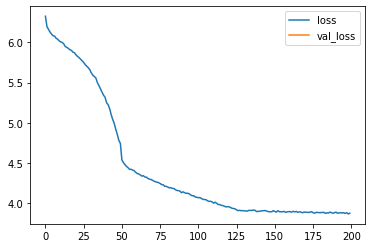

loss =  3.876978635787964 , val_loss =  None
82/82 [==============================] - 53s 652ms/step - loss: 3.8770 - lr: 1.0000e-04


In [20]:
gpt3_model.fit(train_X_1, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

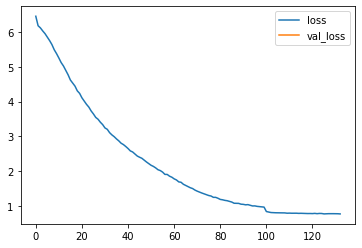

loss =  0.7640930414199829 , val_loss =  None
82/82 [==============================] - 53s 651ms/step - loss: 0.7641 - lr: 1.0000e-03
Epoch 134/200
43/82 [==============>...............] - ETA: 25s - loss: 0.8017

In [ ]:
gpt3_model.fit(train_X_2, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

In [ ]:
gpt3_model.fit(train_X_3, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

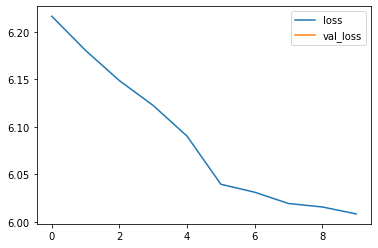

loss =  6.0083208084106445 , val_loss =  None
82/82 [==============================] - 54s 654ms/step - loss: 6.0083 - lr: 1.0000e-03


In [ ]:
gpt3_model.fit(train_X_4, train_y, epochs=200, batch_size=4, callbacks=[plot_losses, lr_scheduler])

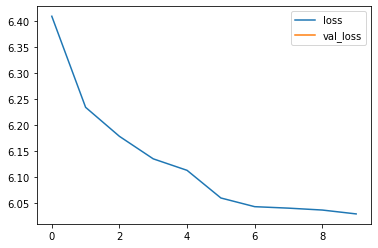

loss =  6.028957366943359 , val_loss =  None
82/82 [==============================] - 54s 655ms/step - loss: 6.0290 - lr: 1.0000e-03


In [ ]:
gpt3_model.fit(train_X_5, train_y, epochs=100, batch_size=4, validation_split=0.1, callbacks=[plot_losses, lr_scheduler])

# 10. Tokenize Test Input

In [ ]:
# max_key_len=180

In [39]:
keyword = "여름"
input_id = tokenizer.encode(keyword, return_tensors='pt')
# bos_token = [tokenizer.bos_token]
# eos_token = [tokenizer.eos_token]

# tokens = bos_token + tokenizer.tokenize(keyword) + eos_token
# input_id = tokenizer.convert_tokens_to_ids(tokens)
# input_id = pad_sequences([input_id], maxlen=max_key_len, value=tokenizer.pad_token_id, padding='post')[0]

# input_id = np.array(input_id, dtype=int).reshape((-1,1))

# input_ids1 = tokenizer(keyword, return_tensors='pt').input_ids
#input_ids1.unsqueeze(0)

# 11. Generate Poem

In [40]:
with torch.no_grad():
  gen_id = gpt3_model.generate(input_id, 
                               min_length = 5, 
                               max_length=180, 
                               pad_token_id=tokenizer.pad_token_id, 
                               eos_token_id=tokenizer.eos_token_id, 
                               bos_token_id=tokenizer.bos_token_id, 
                               repetition_penalty=2.0, 
                               top_k=50, 
                               top_p=0.92,
                               temperature=0.1, 
                               no_repeat_ngram_size=3)
  gen_text = tokenizer.batch_decode(gen_id, skip_special_tokens=True)

In [41]:
gen_text

['여름\n 무료 처음부터까 서가\n은\n이\n은이오\n \n 한빛어진 난 꽃이,,\n 하나하\n나는 지키고워지고 지는 가한하 살아하나.\n 것은 없는 없 지워 없어 묻힌게처럼을고아미조꽃 이웁 잊내 태어나 않는 청히옥로래 건 악 꽃 선 꽃을 게 저외로운 아름다운미\n붉국운문문\n문의훈글어미한마래도의절문에에절로그나보다 못 메기도혀 누 음 네꾸 현상 만든진모으어서는 날려인 사마른']

In [ ]:
  gen_id = gpt3_model.generate(input_id, min_length = 5, max_length=180, temperature=0.9, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, bos_token_id=tokenizer.bos_token_id, repetition_penalty=2.0, top_k=50)


# 12. Model Save

In [33]:
import os
model_name = "skt-ko-gpt-trinity-1.2B-v0.5-new-3"
save_path = os.path.join('/gdrive/MyDrive/Colab Notebooks/sw-project/SW-Project/', model_name)
os.makedirs(save_path)
gpt3_model.save_pretrained(save_path)